<a href="https://colab.research.google.com/github/rajeevsai12/CECS-550-PR-Project/blob/main/CECS_PR_FINAL_PROJECT_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTING ALL THE REQUIRED LIBRARIES

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE

from IPython.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [2]:
def create_data_subset(range=None, dir_path=None, dropna = True): 
  if range == None or dir_path == None :
    raise Exception("please provide subset range as tuple and input dir path containing csvs")
  else:
    # Read csv files into dataframes
    user_behavior_logs = pd.read_csv("data_format1/user_log_format1.csv")
    user_profile = pd.read_csv("/content/drive/MyDrive/PRCECS550/data_format1/user_info_format1.csv")
    training_data = pd.read_csv("/content/drive/MyDrive/PRCECS550/data_format1/train_format1.csv")
    testing_data =  pd.read_csv("/content/drive/MyDrive/PRCECS550/data_format1/test_format1.csv")


    print("user behaviour\n",user_behavior_logs.head(10)) 
    print("user profile\n",user_profile.head(10)) 
    print("training\n",training_data.head(10)) 
    print("testing\n",testing_data.head(10))

    # Rename the 'seller_id' column in user_behavior_logs to 'merchant_id'
    user_behavior_logs = user_behavior_logs.rename(columns={'seller_id': 'merchant_id'})

    # Merge user_behavior_logs with user_profile and training_data
    merged_dataset_training = user_behavior_logs.merge(user_profile, on='user_id', how='left').merge(training_data, on=['user_id', 'merchant_id'], how='left')
    print("merged training\n", merged_dataset_training.head(10)) 
    
    # Filter merged_dataset_training based on the item_id range 
    dataset_training = merged_dataset_training[(merged_dataset_training['item_id'] >= range[0]) & (merged_dataset_training['item_id'] <= range[1])]

    # Drop the data without labels
    dataset_training = dataset_training.dropna(subset=['label'])

    # Replace NULL values in the 'age_range' column with 0 (unknown) 
    dataset_training['age_range'] = dataset_training['age_range'].fillna(0)

    # Replace NULL values in the 'gender' column with 2 (unknown)
    dataset_training['gender'] = dataset_training['gender'].fillna(2)
    dataset_training.to_csv("dataset_training.csv", sep='\t', encoding='utf-8', index=False)
    print(list(dataset_training.columns))

    # Merge user_behavior_logs with user_profile and testing_data
    merged_dataset_testing = user_behavior_logs.merge(user_profile, on='user_id', how='left').merge(testing_data, on=['user_id', 'merchant_id'], how='left')
    print("merged testing\n", merged_dataset_testing.head(10)) 
    
    # Filter merged_dataset_testing based on the item_id range 
    dataset_testing = merged_dataset_testing[(merged_dataset_testing['item_id'] >= range[0]) & (merged_dataset_testing['item_id'] <= range[1])]

    # Replace NULL values in the 'age_range' column with 0 (unknown)
    dataset_testing['age_range'] = dataset_testing['age_range'].fillna(0) 
    
    # Replace NULL values in the 'gender' column with 2 (unknown)
    dataset_testing['gender'] = dataset_testing['gender'].fillna(2) 
    dataset_testing.to_csv("dataset_testing.csv", sep='\t', encoding='utf-8', index=False) 
    
    print(list(dataset_testing.columns))

In [3]:
main_dataset = pd.read_csv("dataset_training.csv", sep="\t") 
print("main_dataset.columns",list(main_dataset.columns))

main_dataset.columns ['user_id', 'item_id', 'cat_id', 'merchant_id', 'brand_id', 'time_stamp', 'action_type', 'age_range', 'gender', 'label']


In [4]:
print(main_dataset.head(10))

   user_id  item_id  cat_id  merchant_id  brand_id  time_stamp  action_type  \
0   232675     1299     602         2569       9.0        1110            0   
1   151261     1370     267         1752    6976.0        1111            2   
2   151261     1370     267         1752    6976.0        1111            0   
3    26523     1339    1467          747    7685.0        1110            0   
4    86476     1289    1025         2876    5178.0        1111            0   
5    86476     1289    1025         2876    5178.0        1111            2   
6    86476     1289    1025         2876    5178.0        1111            0   
7    86476     1289    1025         2876    5178.0        1111            0   
8    86476     1289    1025         2876    5178.0        1111            0   
9    86476     1289    1025         2876    5178.0        1111            0   

   age_range  gender  label  
0        5.0     1.0    0.0  
1        5.0     1.0    0.0  
2        5.0     1.0    0.0  
3        0

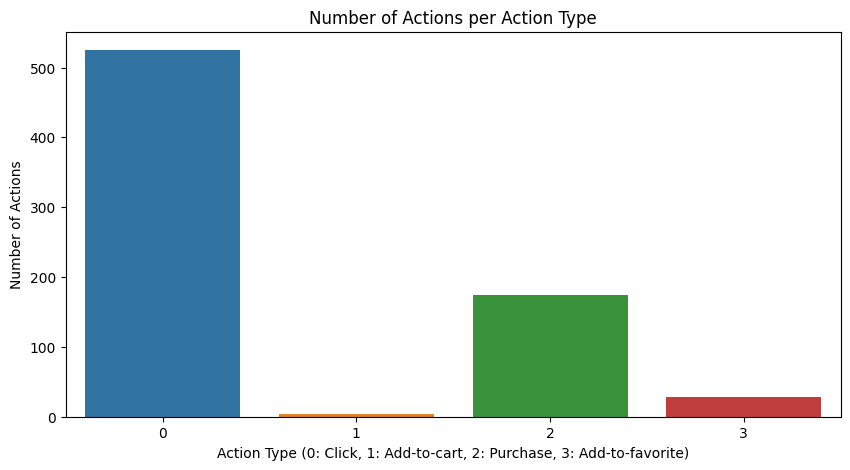

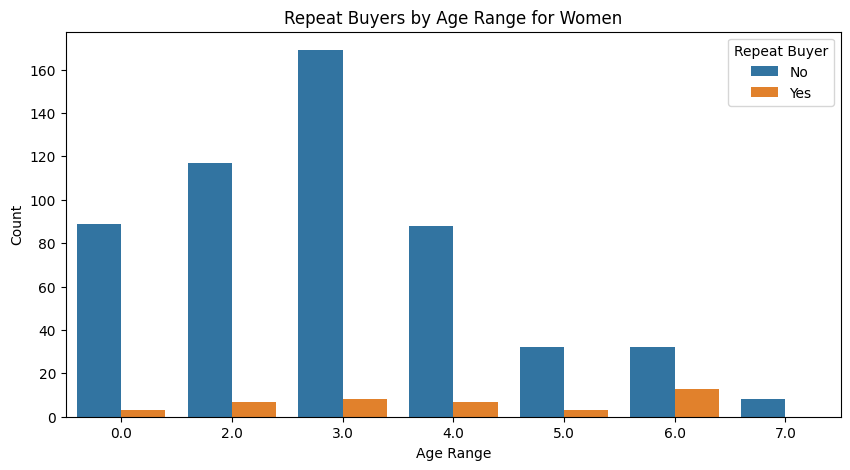

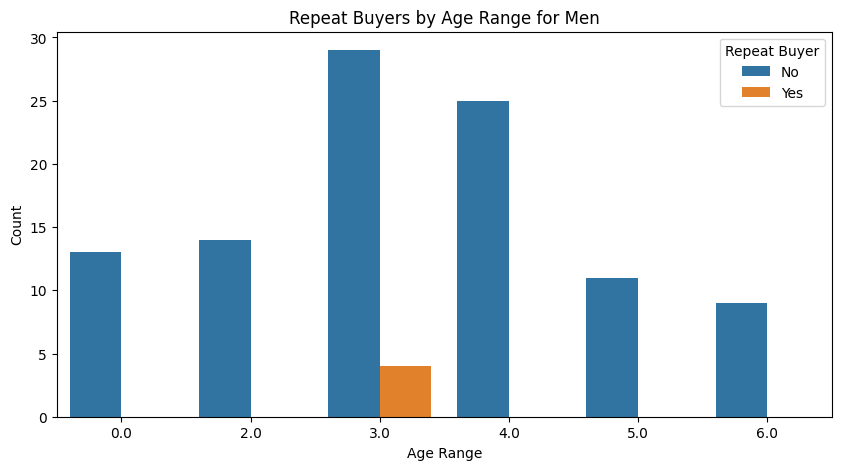

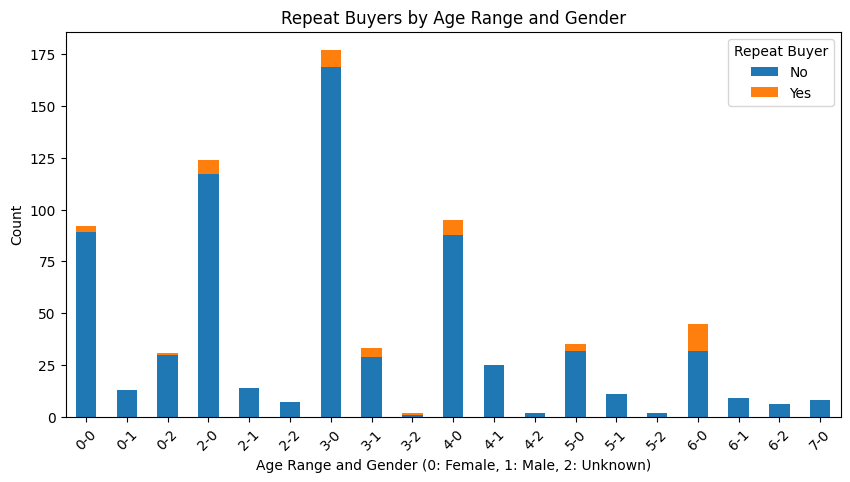

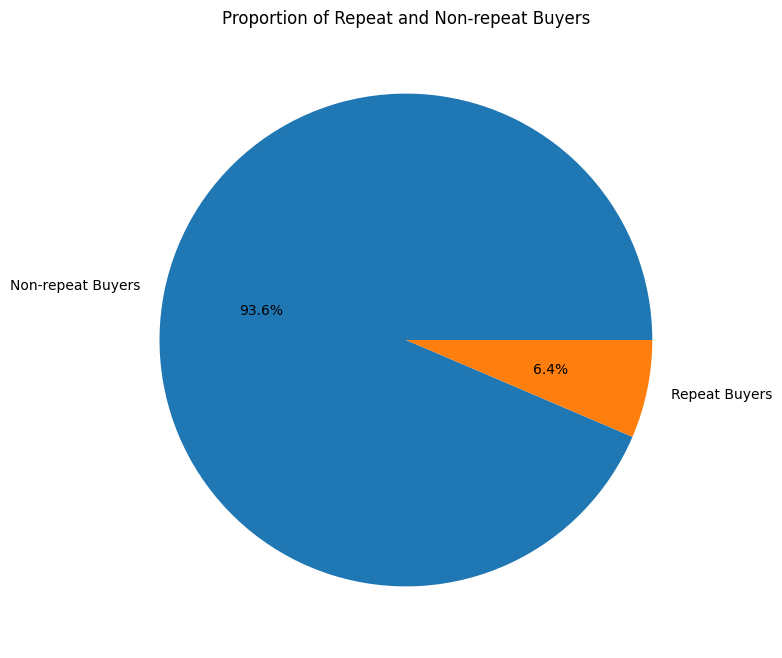

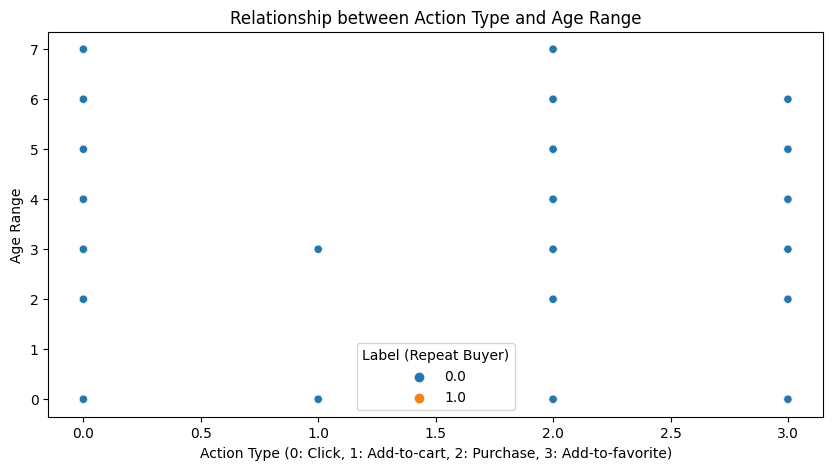

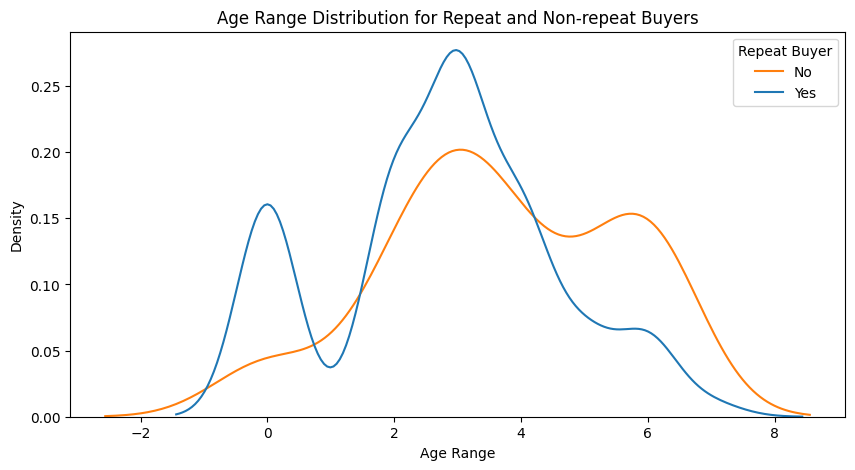

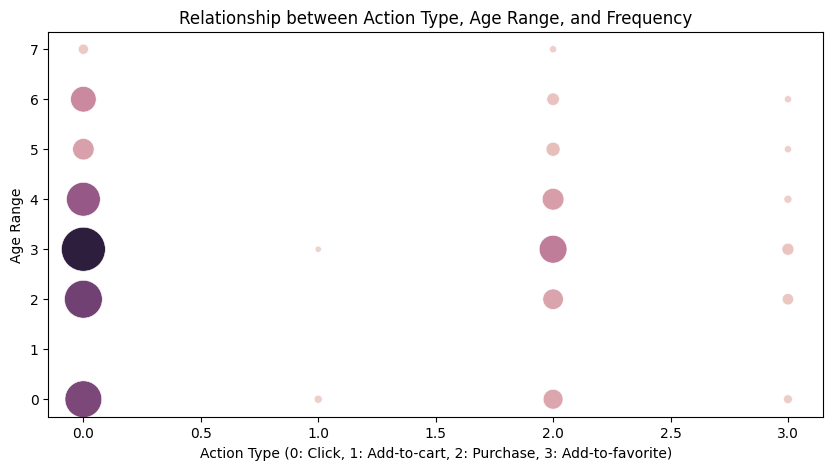

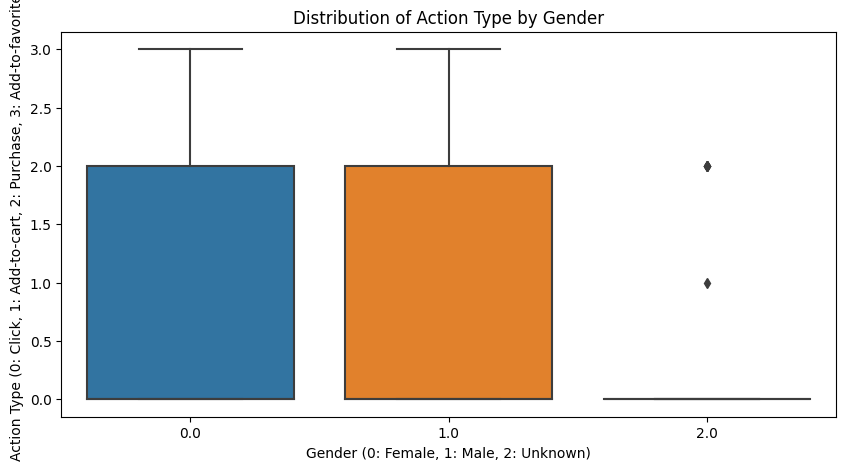

In [5]:
# 1. Data visualization: Visually analyzing the given dataset using the right visualization technique to present the information.


action_counts = main_dataset['action_type'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=action_counts.index, y=action_counts.values)
plt.title('Number of Actions per Action Type')
plt.xlabel('Action Type (0: Click, 1: Add-to-cart, 2: Purchase, 3: Add-to-favorite)') 
plt.ylabel('Number of Actions') 
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='age_range', hue='label', data=main_dataset[main_dataset['gender'] == 0]) 
plt.title('Repeat Buyers by Age Range for Women') 
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.legend(title='Repeat Buyer', labels=['No', 'Yes'])
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='age_range', hue='label', data=main_dataset[main_dataset['gender'] == 1]) 
plt.title('Repeat Buyers by Age Range for Men') 
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.legend(title='Repeat Buyer', labels=['No', 'Yes'])
plt.show()

age_gender_repeat_buyer = main_dataset.groupby(['age_range', 'gender', 'label']).size().reset_index(name='count')
age_gender_repeat_buyer_pivot = age_gender_repeat_buyer.pivot_table(index=['age_range', 'gender'], columns='label', values='count').reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
age_gender_repeat_buyer_pivot.set_index(['age_range', 'gender']).plot(kind='bar', stacked=True, ax=ax)
plt.title('Repeat Buyers by Age Range and Gender')
plt.xlabel('Age Range and Gender (0: Female, 1: Male, 2: Unknown)') 
plt.ylabel('Count') 
plt.xticks(ticks=range(len(age_gender_repeat_buyer_pivot)), labels=[f"{int(row['age_range'])}-{int(row['gender'])}" for _, row in age_gender_repeat_buyer_pivot.iterrows()], rotation=45) 
plt.legend(title='Repeat Buyer', labels=['No', 'Yes']) 
plt.show()

labels_counts = main_dataset['label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(labels_counts.values, labels=['Non-repeat Buyers', 'Repeat Buyers'], autopct='%1.1f%%')
plt.title('Proportion of Repeat and Non-repeat Buyers') 
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x='action_type', y='age_range', hue='label', data=main_dataset)
plt.title('Relationship between Action Type and Age Range')
plt.xlabel('Action Type (0: Click, 1: Add-to-cart, 2: Purchase, 3: Add-to-favorite)')
plt.ylabel('Age Range') 
plt.legend(title='Label (Repeat Buyer)') 
plt.show()

plt.figure(figsize=(10, 5))
sns.kdeplot(data=main_dataset, x='age_range', hue='label', common_norm=False) 
plt.title('Age Range Distribution for Repeat and Non-repeat Buyers')
plt.xlabel('Age Range')
plt.ylabel('Density')
plt.legend(title='Repeat Buyer', labels=['No', 'Yes'])
plt.show()

action_age_count = main_dataset.groupby(['action_type', 'age_range']).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.scatterplot(x='action_type', y='age_range', size='count', hue='count', data=action_age_count, sizes=(20, 1000), legend=False) 
plt.title('Relationship between Action Type, Age Range, and Frequency') 
plt.xlabel('Action Type (0: Click, 1: Add-to-cart, 2: Purchase, 3: Add-to-favorite)') 
plt.ylabel('Age Range') 
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='gender', y='action_type', data=main_dataset)
plt.title('Distribution of Action Type by Gender')
plt.xlabel('Gender (0: Female, 1: Male, 2: Unknown)')
plt.ylabel('Action Type (0: Click, 1: Add-to-cart, 2: Purchase, 3: Add-to-favorite)') 
plt.show()


In [6]:
# 2.Feature engineering

def create_new_features(main_dataset):

  # Total actions count
  total_actions = main_dataset.groupby(['user_id'])['action_type'].count().reset_index(name='total_actions')

  # Count of each action type
  action_counts = main_dataset.pivot_table(index='user_id', columns='action_type', aggfunc='size', fill_value=0).reset_index()
  action_counts.columns = ['user_id', 'clicks', 'add_to_carts', 'purchases', 'add_to_favourites']

  # Number of unique items and categories interacted with
  unique_counts = main_dataset.groupby('user_id').agg({'item_id': 'nunique', 'cat_id': 'nunique'}).reset_index()
  unique_counts.columns = ['user_id', 'unique_items', 'unique_categories']

  # Average action count per age_range
  avg_actions_per_age = main_dataset.groupby(['age_range'])['action_type'].count().reset_index(name='avg_actions_per_age')
  main_dataset = main_dataset.merge(avg_actions_per_age, on='age_range', how='left')

  # Average action count per gender
  avg_actions_per_gender = main_dataset.groupby(['gender'])['action_type'].count().reset_index(name='avg_actions_per_gender')
  main_dataset = main_dataset.merge(avg_actions_per_gender, on='gender', how='left')

  # Merge all the derived features into a single DataFrame
  derived_features = total_actions.merge(action_counts, on='user_id', how='outer').merge(unique_counts, on='user_id', how='outer')

  # Now, let's merge the age_range, gender, avg_actions_per_age, and␣ ↪avg_actions_per_gender columns from the main_dataset
  user_age_gender = main_dataset[['user_id', 'age_range', 'gender', 'avg_actions_per_age', 'avg_actions_per_gender']].drop_duplicates()

  # Merge derived_features with user_age_gender
  all_derived_features = derived_features.merge(user_age_gender, on='user_id', how='outer')
  print("all_derived_features", list(all_derived_features.columns))

  # List of derived features
  derived_feature_columns = list(all_derived_features.columns)

  # Exclude 'user_id' from the list of derived features for plotting
  derived_feature_columns.remove('user_id')

  # Calculate the number of rows and columns for the subplots
  n_rows = int(len(derived_feature_columns) // 2) + len(derived_feature_columns) % 2
  n_cols = 2

  # Create a figure and subplots for the derived features
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5)) 
  
  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Plot histograms for each derived feature in the dataset
  for i, column in enumerate(derived_feature_columns): 
    axes[i].hist(all_derived_features[column], bins=30, edgecolor='black') 
    axes[i].set_title(f'Distribution of {column}') 
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

  # Remove any unused subplots
  for i in range(len(derived_feature_columns), n_rows * n_cols): 
    fig.delaxes(axes[i])

  plt.tight_layout(pad=3.0) 
  
  # Increase padding between subplots 
  plt.show()

  # Plot a correlation matrix heatmap for the derived features
  plt.figure(figsize=(12, 8))
  sns.heatmap(all_derived_features[derived_feature_columns].corr(), annot=True, cmap='coolwarm', center=0)
  plt.title("Correlation Matrix Heatmap of Derived Features")
  plt.show()

  print("all_derived_features",list(all_derived_features.columns))

  # Add derived features to the dataset
  main_dataset_merged = main_dataset.merge(all_derived_features, on='user_id', how='left')

  # Fill missing values in the main_dataset with the mode of each column
  main_dataset_merged = main_dataset_merged.fillna(main_dataset_merged.mode().iloc[0])
  selected_columns = main_dataset_merged.columns.tolist()
  selected_columns.remove('user_id')
  selected_columns.remove('label')

  # Plot a correlation matrix heatmap for the selected features 
  plt.figure(figsize=(16, 12)) 
  sns.heatmap(main_dataset_merged[selected_columns].corr(), annot=True, cmap='coolwarm', center=0)
  plt.title("Correlation Matrix Heatmap of Original and Derived Features") 
  plt.show()


  print("merged main_dataset\n",list(main_dataset_merged.columns)) 
  return main_dataset_merged

all_derived_features ['user_id', 'total_actions', 'clicks', 'add_to_carts', 'purchases', 'add_to_favourites', 'unique_items', 'unique_categories', 'age_range', 'gender', 'avg_actions_per_age', 'avg_actions_per_gender']


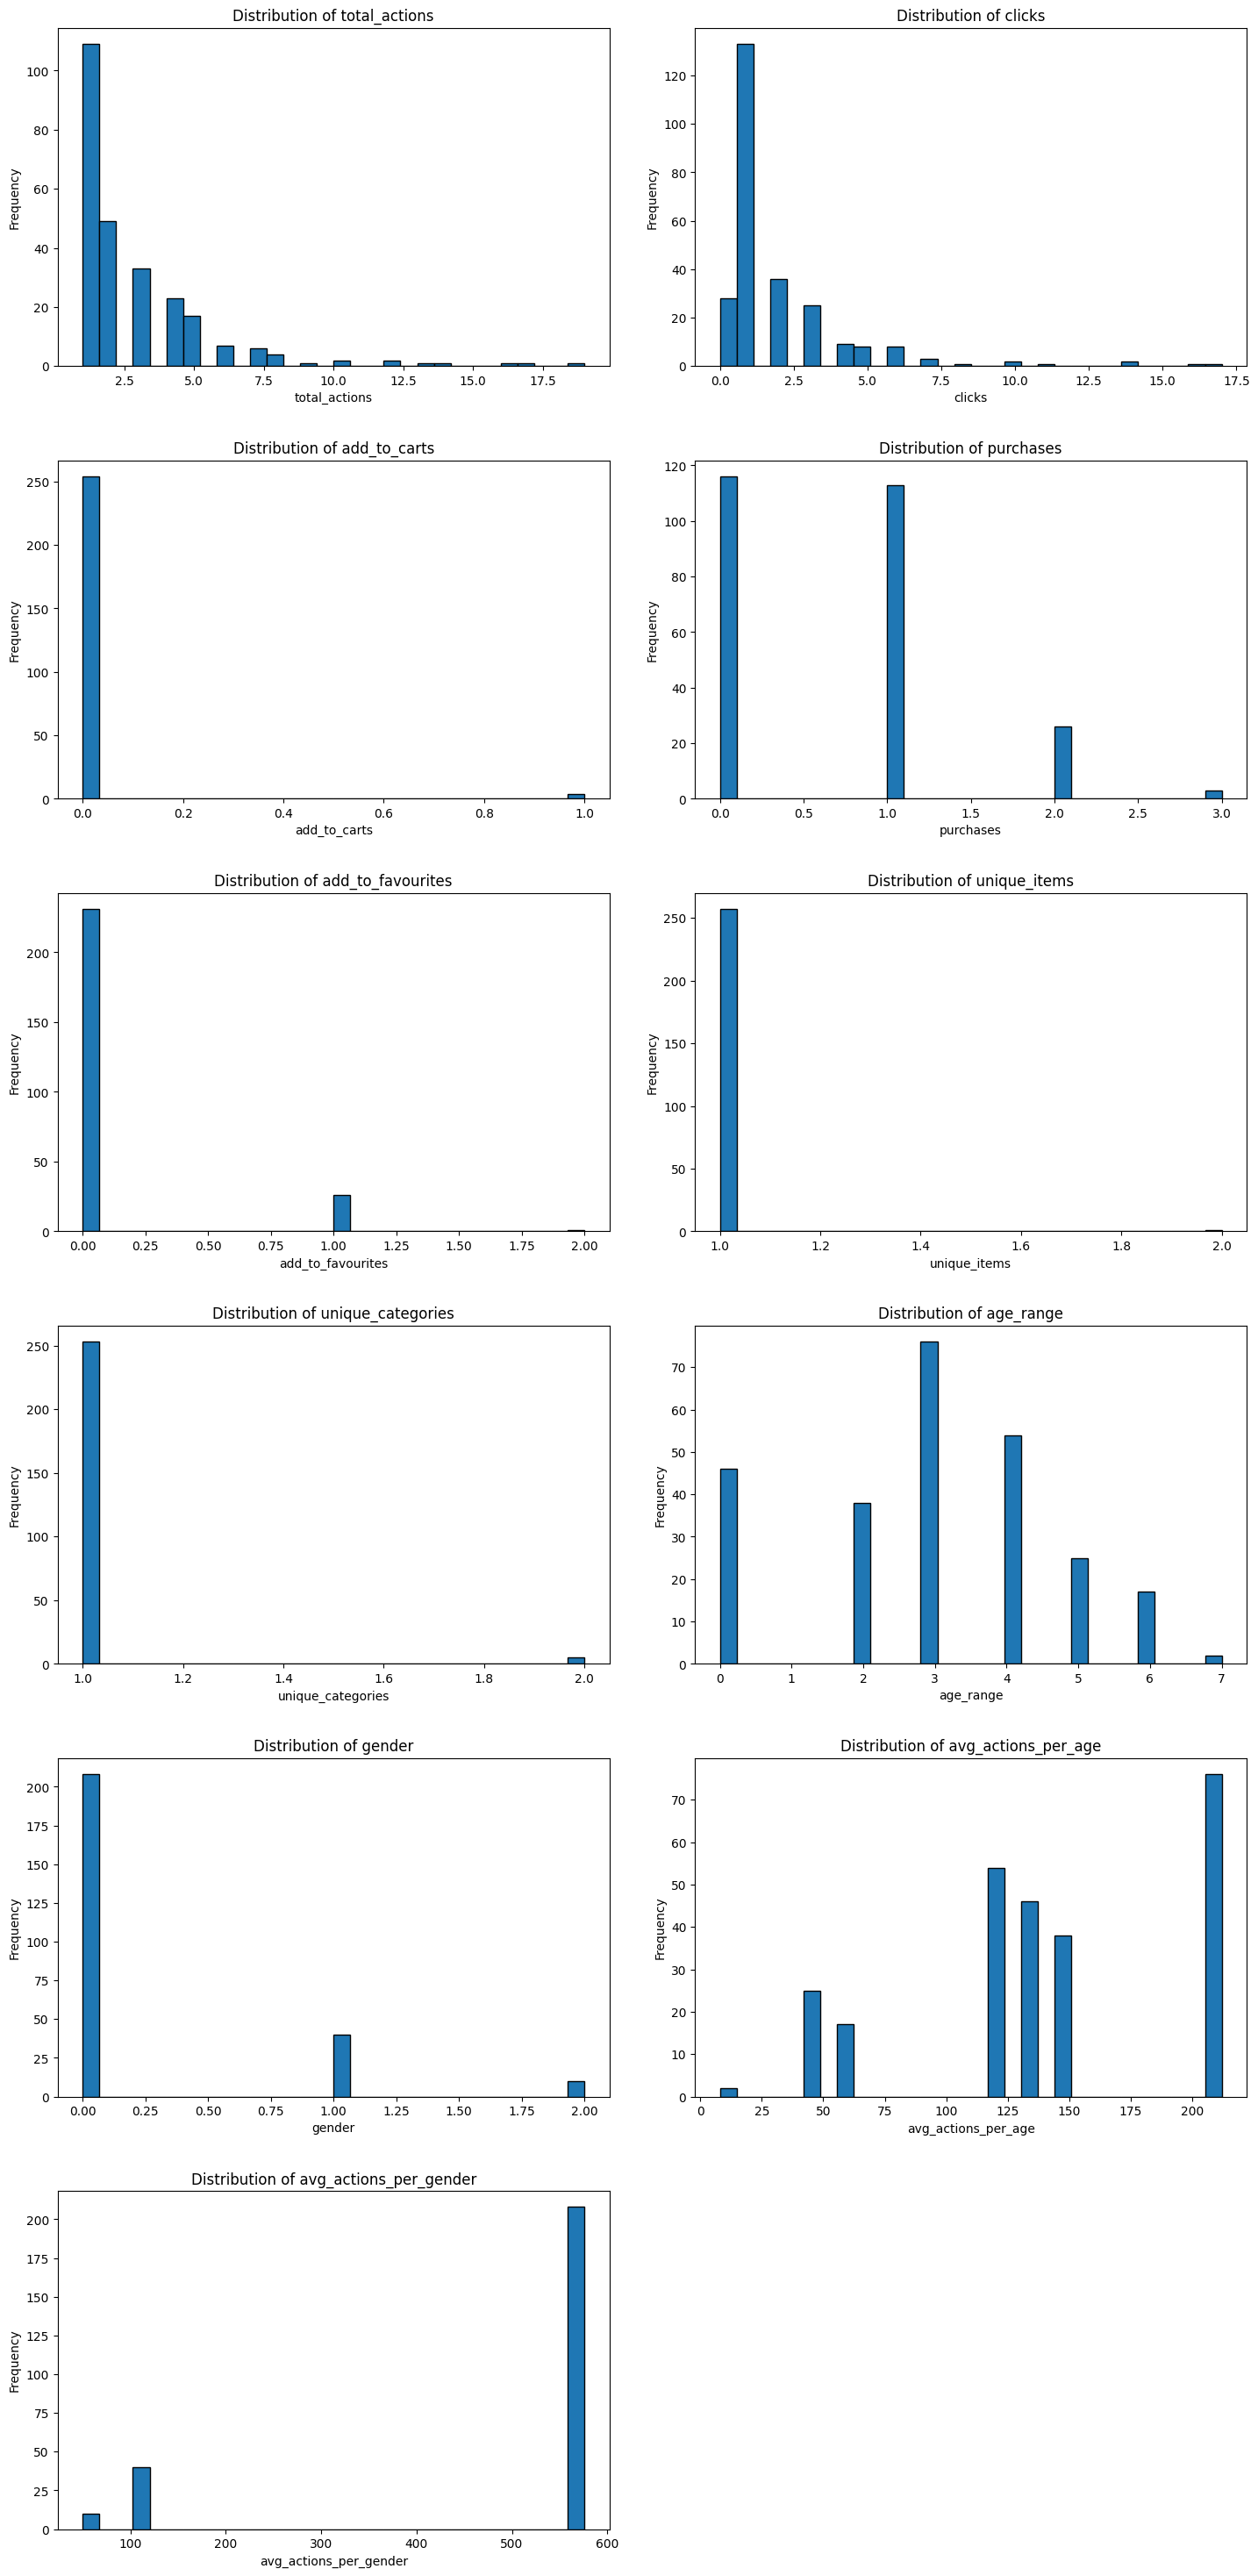

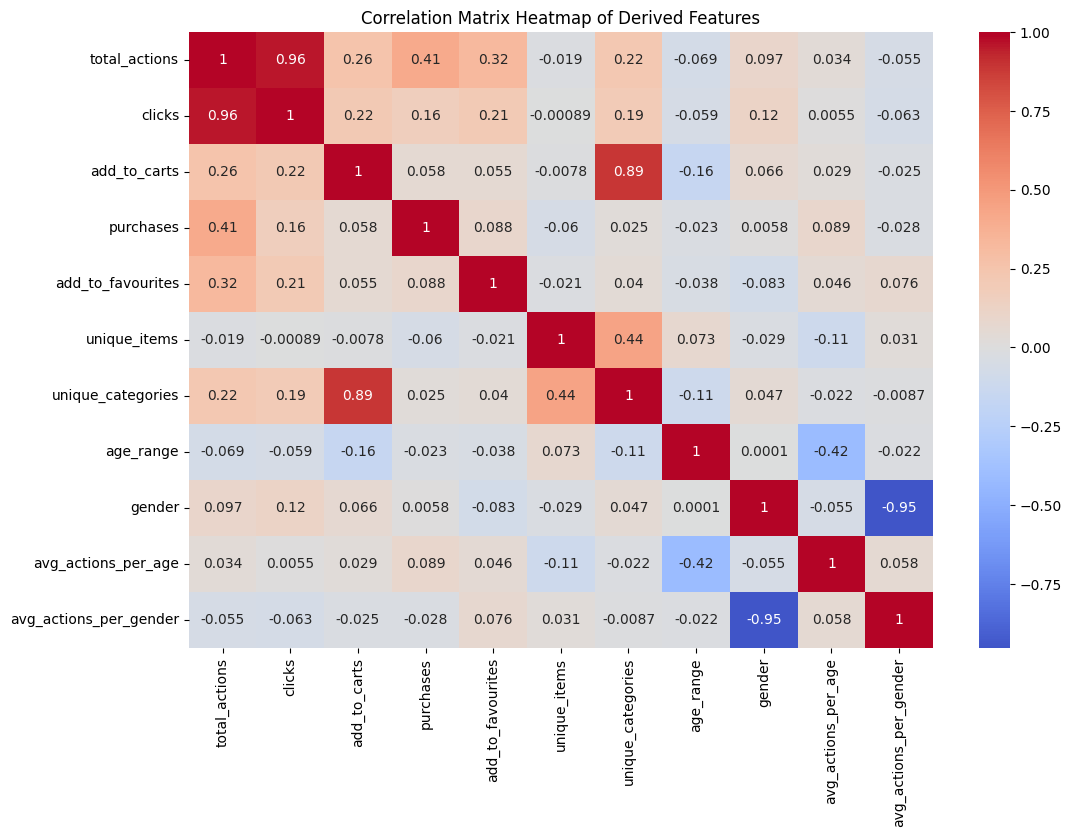

all_derived_features ['user_id', 'total_actions', 'clicks', 'add_to_carts', 'purchases', 'add_to_favourites', 'unique_items', 'unique_categories', 'age_range', 'gender', 'avg_actions_per_age', 'avg_actions_per_gender']


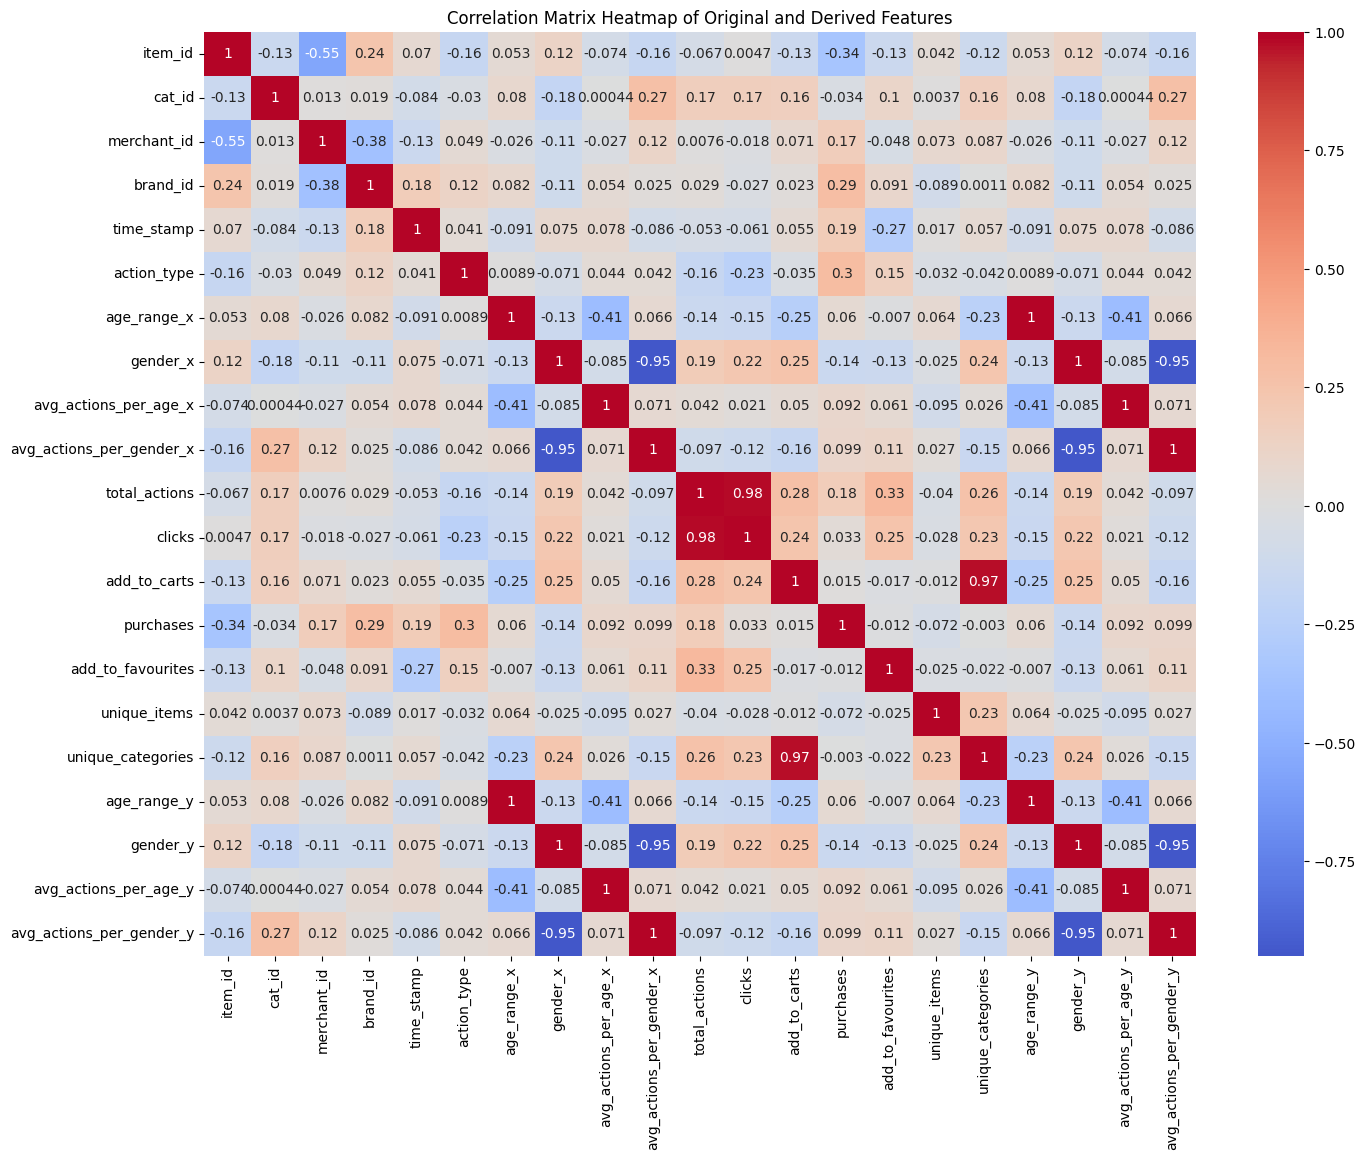

merged main_dataset
 ['user_id', 'item_id', 'cat_id', 'merchant_id', 'brand_id', 'time_stamp', 'action_type', 'age_range_x', 'gender_x', 'label', 'avg_actions_per_age_x', 'avg_actions_per_gender_x', 'total_actions', 'clicks', 'add_to_carts', 'purchases', 'add_to_favourites', 'unique_items', 'unique_categories', 'age_range_y', 'gender_y', 'avg_actions_per_age_y', 'avg_actions_per_gender_y']


In [7]:
main_dataset_merged = create_new_features(main_dataset=main_dataset)

In [10]:
# 3.Dataset statistics and feature ranking

def perform_statistical_summary(main_dataset, title):

  stats_summary = main_dataset.describe()
  print(title, stats_summary)

  # Plot box plots for each numeric variable in the dataset 
  plt.figure(figsize=(15, 10)) 
  sns.boxplot(data=main_dataset.drop(columns=['user_id']), orient='h') 
  plt.title(title)
  plt.show()

  num_columns = main_dataset.select_dtypes(include=['int64', 'float64']).drop(columns=['user_id']).columns

  # Calculate the number of rows and columns for the subplots
  n_rows = int(len(num_columns) // 2) + len(num_columns) % 2
  n_cols = 3

  # Create a figure and subplots for the numeric variables
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 10)) 
  
  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Plot histograms for each numeric variable in the dataset
  for i, column in enumerate(num_columns): 
    axes[i].hist(main_dataset[column], bins=30, edgecolor='black') 
    axes[i].set_title(f'distribution plot for {column}') 
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

  # Remove any unused subplots
  for i in range(len(num_columns), n_rows * n_cols): 
    fig.delaxes(axes[i])

  # plt.title("Distribution of features")
  plt.tight_layout(h_pad=30.0)
  plt.show()

Statistical summary of the dataset before new features
              user_id      item_id       cat_id  merchant_id     brand_id  \
count     731.000000   731.000000   731.000000   731.000000   727.000000   
mean   212705.017784  1313.261286   800.370725  2587.928865  4959.546080   
std    123455.613331    40.100509   379.252698   892.401383  2065.264096   
min       820.000000  1289.000000    36.000000    41.000000     9.000000   
25%    106087.000000  1289.000000   602.000000  2569.000000  5178.000000   
50%    205296.000000  1289.000000  1025.000000  2876.000000  5178.000000   
75%    315413.000000  1312.500000  1025.000000  2876.000000  6326.000000   
max    423949.000000  1440.000000  1505.000000  4976.000000  8231.000000   

        time_stamp  action_type   age_range      gender       label  
count   731.000000   731.000000  731.000000  731.000000  731.000000  
mean   1074.341997     0.596443    2.831737    0.280438    0.064295  
std     109.929233     0.973590    1.786672    0.

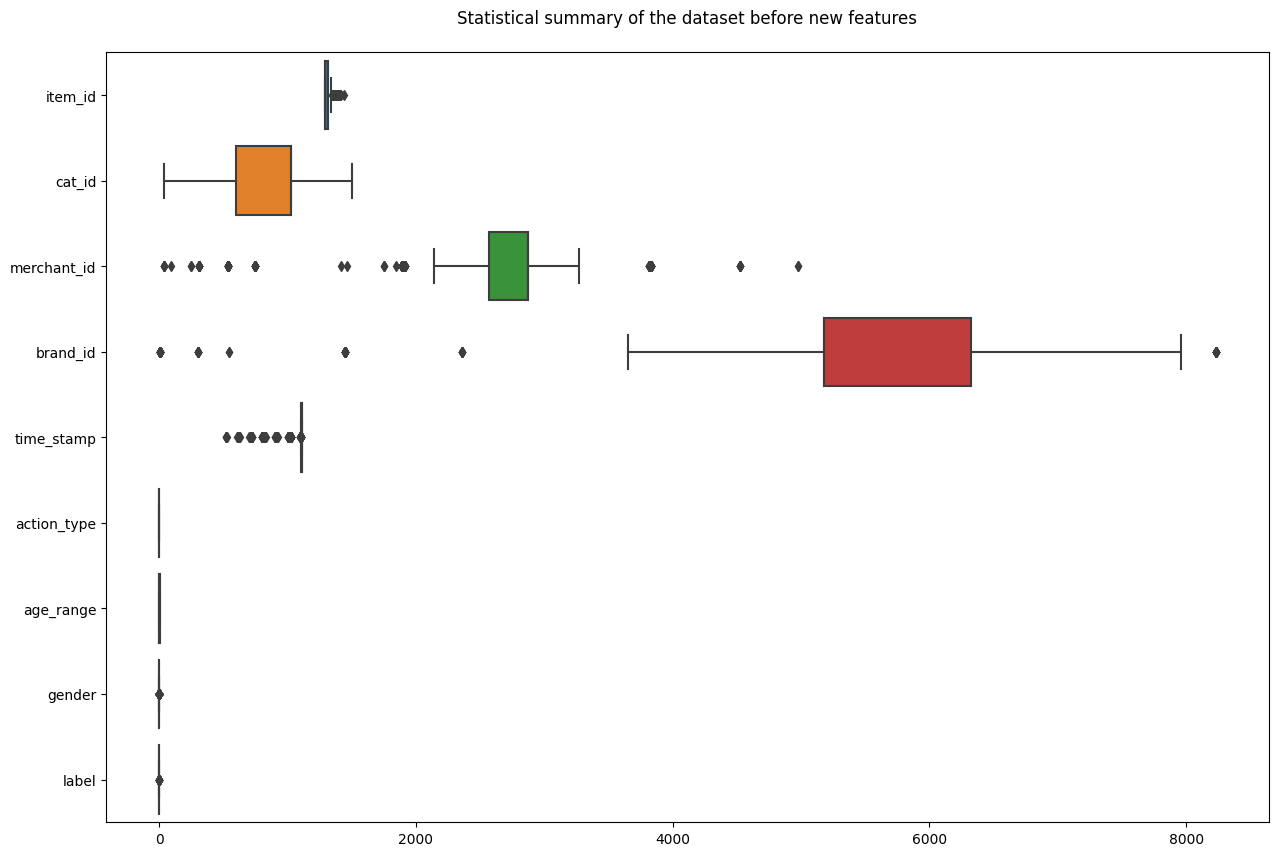

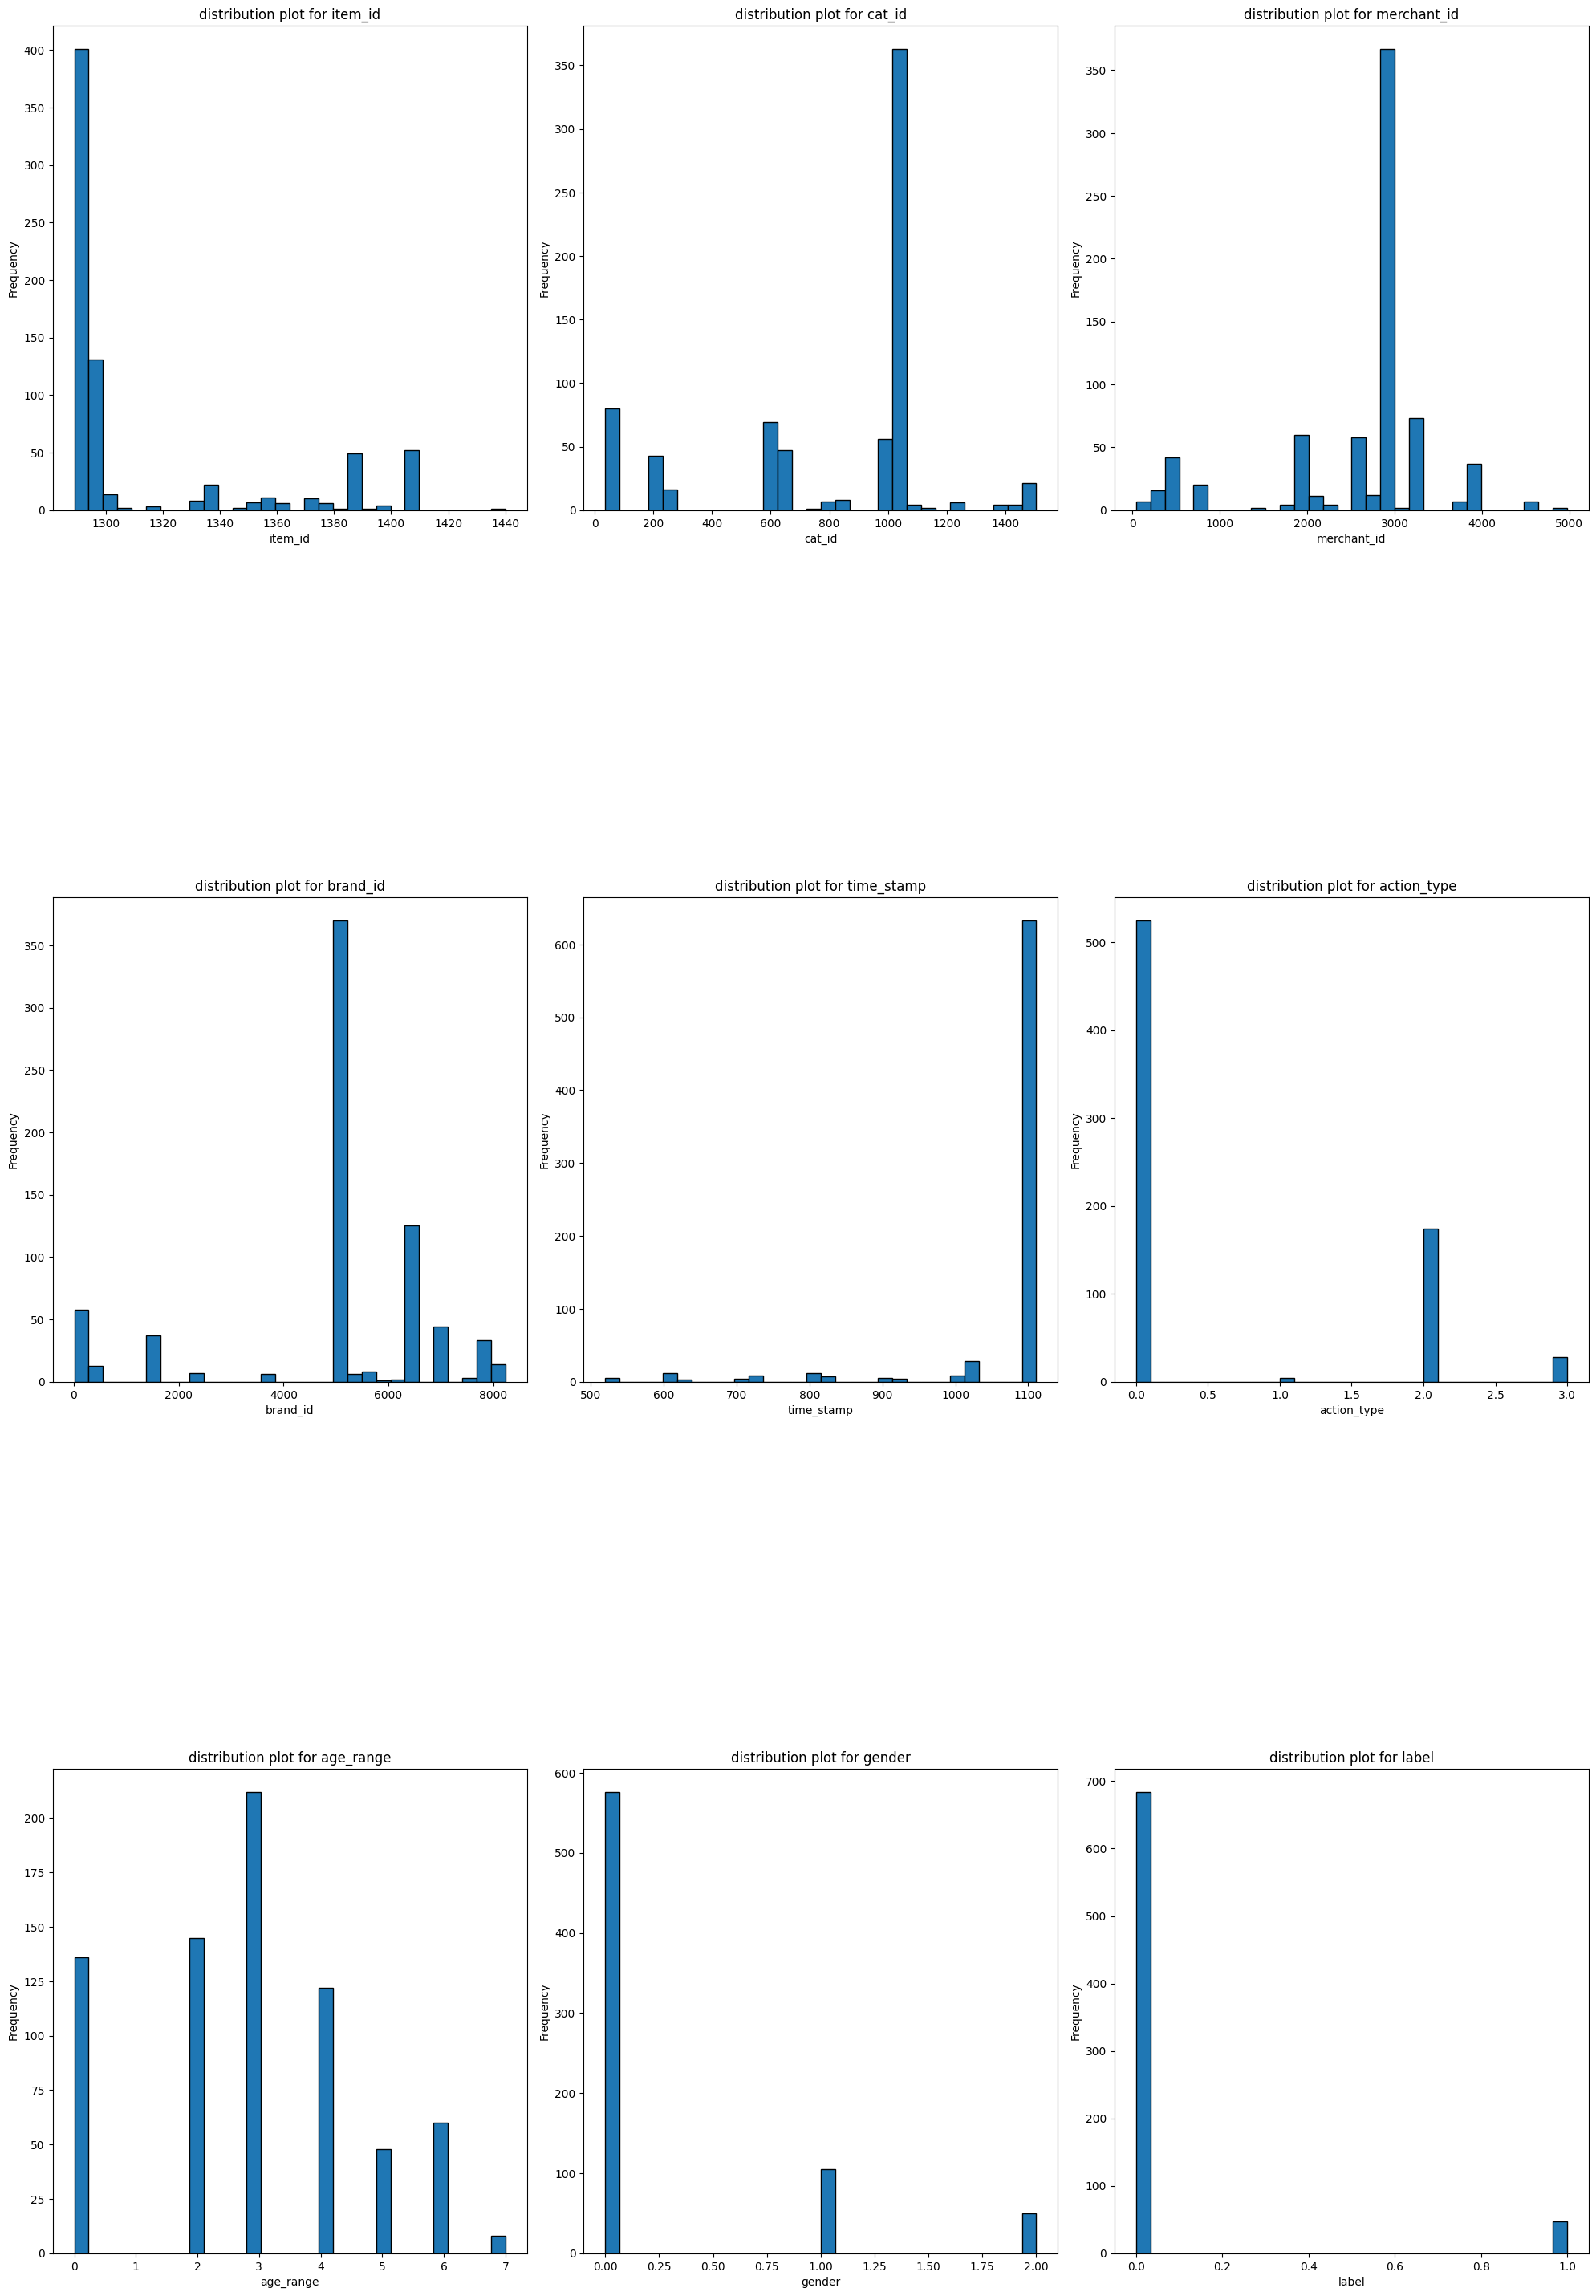

In [11]:
# statistical summary of the dataset

perform_statistical_summary(main_dataset,title="Statistical summary of the dataset before new features\n")

Statistical summary of the dataset after new features              user_id      item_id       cat_id  merchant_id     brand_id  \
count     731.000000   731.000000   731.000000   731.000000   731.000000   
mean   212705.017784  1313.261286   800.370725  2587.928865  4960.741450   
std    123455.613331    40.100509   379.252698   892.401383  2059.661198   
min       820.000000  1289.000000    36.000000    41.000000     9.000000   
25%    106087.000000  1289.000000   602.000000  2569.000000  5178.000000   
50%    205296.000000  1289.000000  1025.000000  2876.000000  5178.000000   
75%    315413.000000  1312.500000  1025.000000  2876.000000  6326.000000   
max    423949.000000  1440.000000  1505.000000  4976.000000  8231.000000   

        time_stamp  action_type  age_range_x    gender_x       label  ...  \
count   731.000000   731.000000   731.000000  731.000000  731.000000  ...   
mean   1074.341997     0.596443     2.831737    0.280438    0.064295  ...   
std     109.929233     0.97359

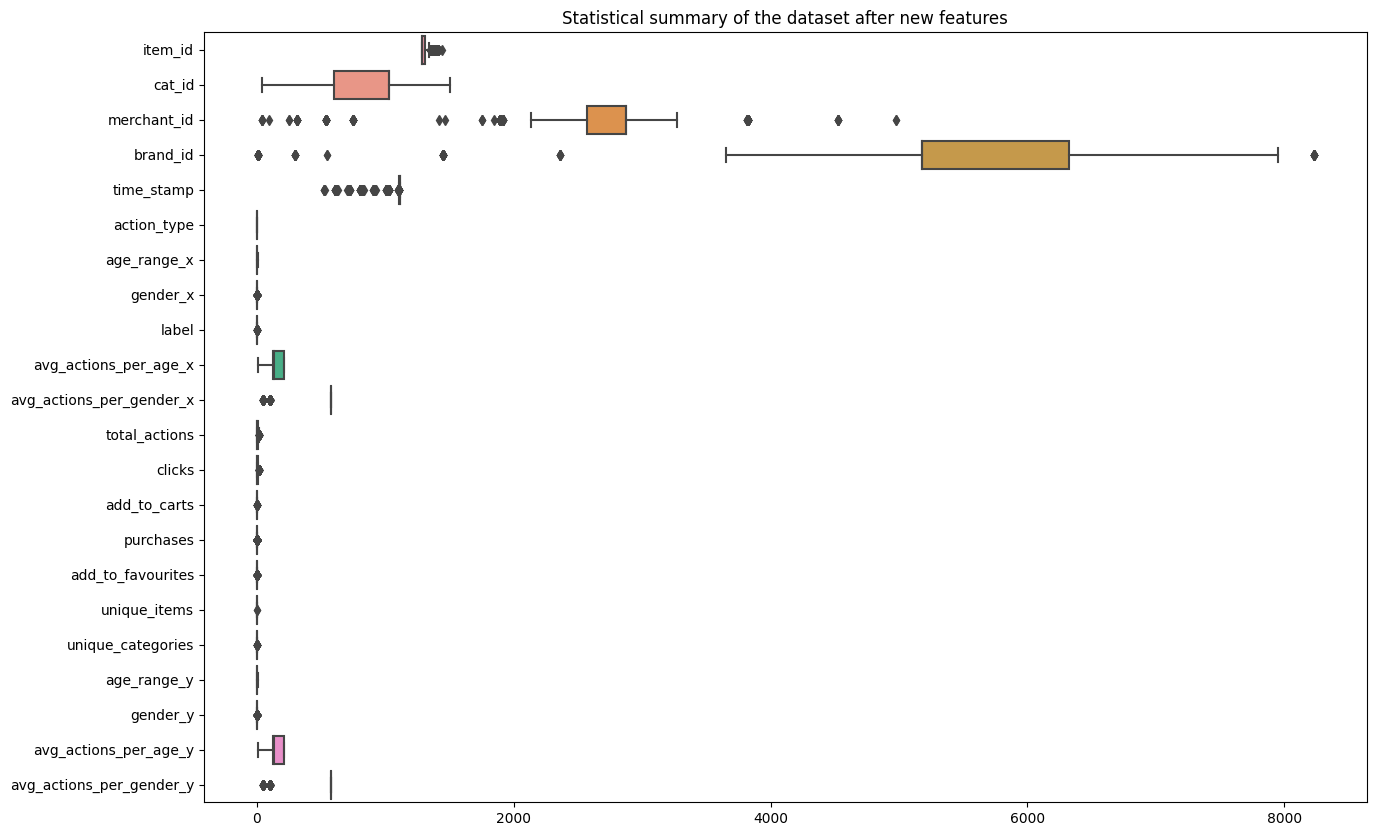

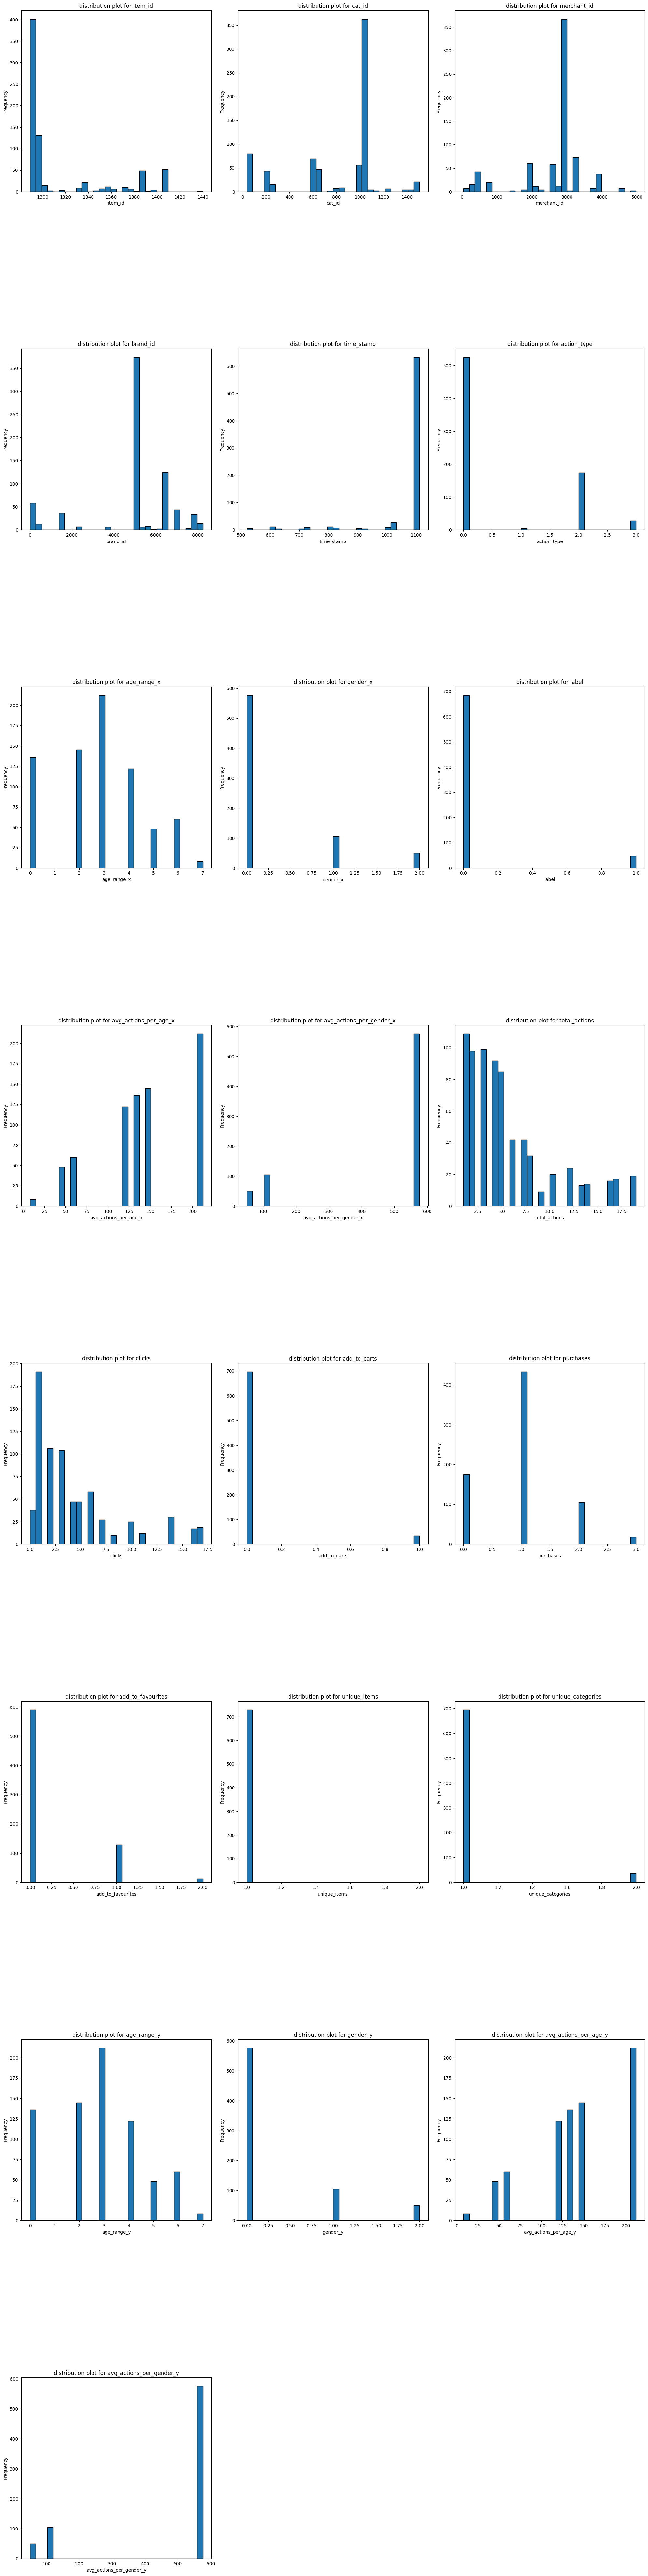

In [12]:
# statistical summary of the dataset with new features

perform_statistical_summary(main_dataset_merged, title="Statistical summary of the dataset after new features")

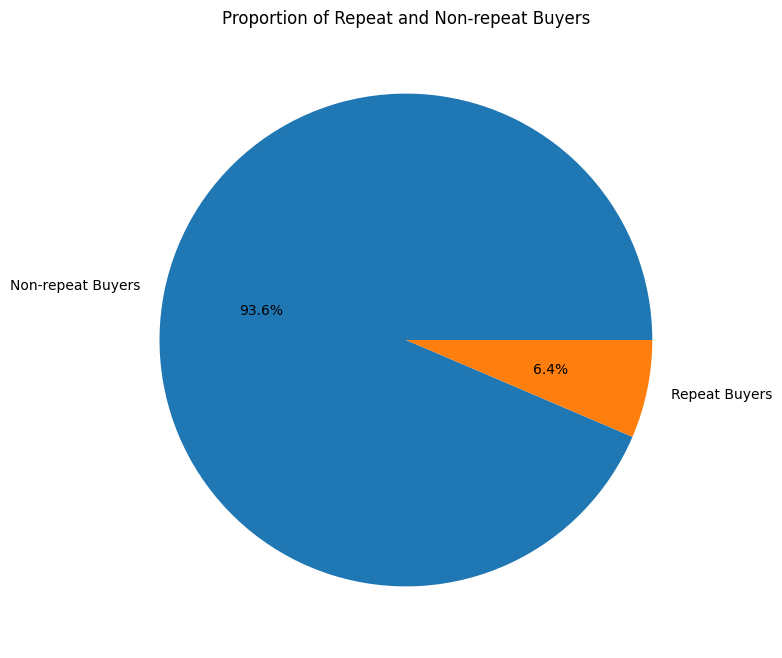

In [13]:
# Creating feature, target arrays for training

labels_counts = main_dataset['label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(labels_counts.values, labels=['Non-repeat Buyers', 'Repeat Buyers'], autopct='%1.1f%%')
plt.title('Proportion of Repeat and Non-repeat Buyers') 
plt.show()

In [14]:
def create_X_Y(main_dataset):

  # Select the columns to be used as features and the target column 
  selected_columns = main_dataset.columns.tolist()
  selected_columns.remove('user_id')
  selected_columns.remove('label')
  target_column = 'label'

  # Separate features (X) and target (y)
  X = main_dataset[selected_columns]
  y = main_dataset[target_column]
  smote = SMOTE()
  X, y = smote.fit_resample(X, y)

  # Handle missing values using SimpleImputer (you can choose a strategy like␣ ↪'mean', 'median', or 'most_frequent')
  imputer = SimpleImputer(strategy='mean')
  X_imputed = imputer.fit_transform(X)

  # Scale the features using StandardScaler
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X_imputed)
  
  # ros = RandomOverSampler(random_state=42)
  return X, y, X_scaled, selected_columns

In [15]:
X, y, X_scaled, selected_columns = create_X_Y(main_dataset=main_dataset_merged)

In [16]:
# Feature ranking

def perform_feature_ranking(X, y, selected_columns ):
  rf = RandomForestClassifier(n_estimators=100, random_state=42) 
  rf.fit(X, y)

  # Get feature importances
  importances = rf.feature_importances_
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, selected_columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")

  #plt.xticks(rotation=45, fontsize=10)
  plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
  plt.xticks(range(X.shape[1]), [selected_columns[i] for i in indices], rotation=90)
  plt.xlim([-1, X.shape[1]])
  plt.tight_layout()
  plt.show()

Feature ranking:
1. feature time_stamp (0.167483)
2. feature total_actions (0.113403)
3. feature clicks (0.094836)
4. feature cat_id (0.074732)
5. feature age_range_y (0.074021)
6. feature age_range_x (0.069115)
7. feature avg_actions_per_age_x (0.064391)
8. feature avg_actions_per_age_y (0.064205)
9. feature purchases (0.061321)
10. feature item_id (0.040772)
11. feature merchant_id (0.038279)
12. feature brand_id (0.032851)
13. feature add_to_favourites (0.024209)
14. feature avg_actions_per_gender_x (0.021337)
15. feature action_type (0.017287)
16. feature avg_actions_per_gender_y (0.016678)
17. feature gender_x (0.013185)
18. feature gender_y (0.008402)
19. feature unique_categories (0.002482)
20. feature add_to_carts (0.000830)
21. feature unique_items (0.000180)


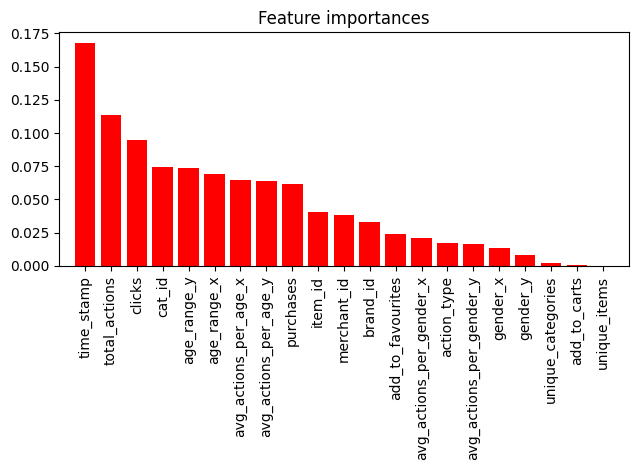

In [17]:
perform_feature_ranking(X, y, selected_columns)

In [18]:
# PCA for feature reduction

def perform_pca(X_scaled,y): 
  pca = PCA()
  X_pca = pca.fit_transform(X_scaled)

  # Plot the explained variance ratio for each component
  plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum())
  plt.xlabel('Number of Components')
  plt.ylabel('Cumulative Explained Variance')
  plt.title('PCA Analysis')
  plt.show()

  # Choose an optimal number of components based on the explained variance (e. ↪g., 90% or 95%)
  optimal_components = (pca.explained_variance_ratio_.cumsum() >= 0.95).argmax() + 1
  print("no of optimal components: ",optimal_components)

  return optimal_components

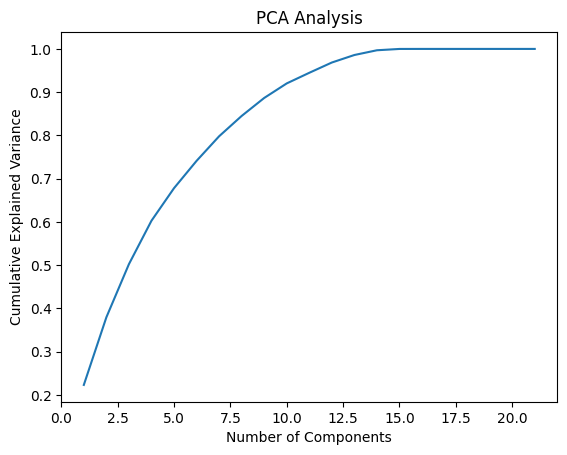

no of optimal components:  12


In [19]:
optimal_components = perform_pca(X_scaled, y)

In [20]:
# splitting the dataset. 80% of data for training and 20% of data for testing

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
# comparative analysis of the model before and after performing PCA

def validate_pca(X_train, X_test, y_train, y_test, X, X_Scaled, optimal_components):
  # Train and evaluate a classification model without PCA
  clf = LogisticRegression()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  accuracy_no_pca = accuracy_score(y_test, y_pred)

  # Train and evaluate a classification model with PCA
  pca = PCA(n_components=optimal_components)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  # Create a DataFrame to display the components and their corresponding features
  components_df = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i + 1}' for i in range(optimal_components)]) 
  
  # Set the plotting style
  sns.set(style='whitegrid')

  # Calculate the total sum of absolute contributions for each feature across all components
  total_contributions = components_df.abs().sum(axis=0).sort_values(ascending=False)
  # Create a bar plot for the total contributions
  plt.figure(figsize=(12, 6))
  sns.barplot(x=total_contributions.index, y=total_contributions.values)

  # Set title and rotate the x-axis labels for better readability
  plt.title("Total sum of absolute feature contributions across all principal components")
  plt.xticks(rotation=60)

  # Show the plot
  plt.tight_layout()
  plt.show()
  clf_pca = LogisticRegression()
  clf_pca.fit(X_train_pca, y_train)
  y_pred_pca = clf_pca.predict(X_test_pca)
  accuracy_pca = accuracy_score(y_test, y_pred_pca)
  print("Accuracy without PCA:", accuracy_no_pca)
  print("Accuracy with PCA:", accuracy_pca)

  # Initialize an empty list to store accuracies
  accuracies = []

  # Iterate through the number of principal components
  for i in range(1, optimal_components + 1):
    # Train and evaluate a classification model with the first i principal components
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf_pca = LogisticRegression()
    clf_pca.fit(X_train_pca, y_train)
    y_pred_pca = clf_pca.predict(X_test_pca)

    # Calculate accuracy and append it to the list
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    accuracies.append(accuracy_pca)

  # Create a line plot for the accuracies
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, optimal_components + 1), accuracies, marker='o', linestyle='-', markersize=6, label="PCA")
  
  # Add the accuracy without PCA as a reference line
  plt.axhline(y=accuracy_no_pca, color='r', linestyle='--', label="No PCA")
  plt.title("Model accuracy with the first i principal components")
  plt.xlabel("Number of principal components")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.tight_layout()
  plt.show()

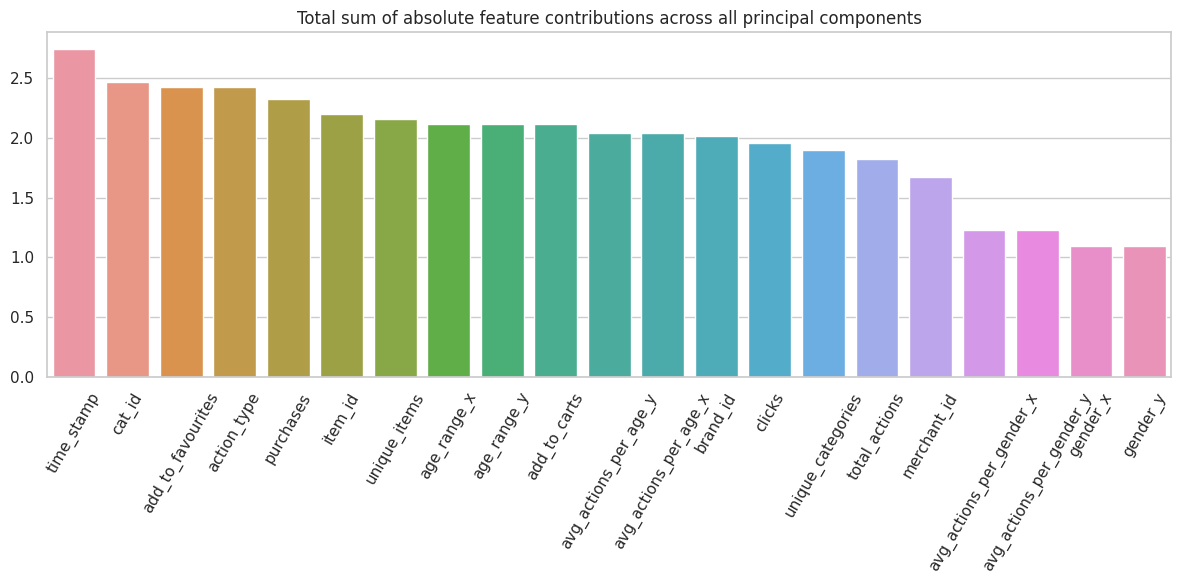

Accuracy without PCA: 0.7773722627737226
Accuracy with PCA: 0.7408759124087592


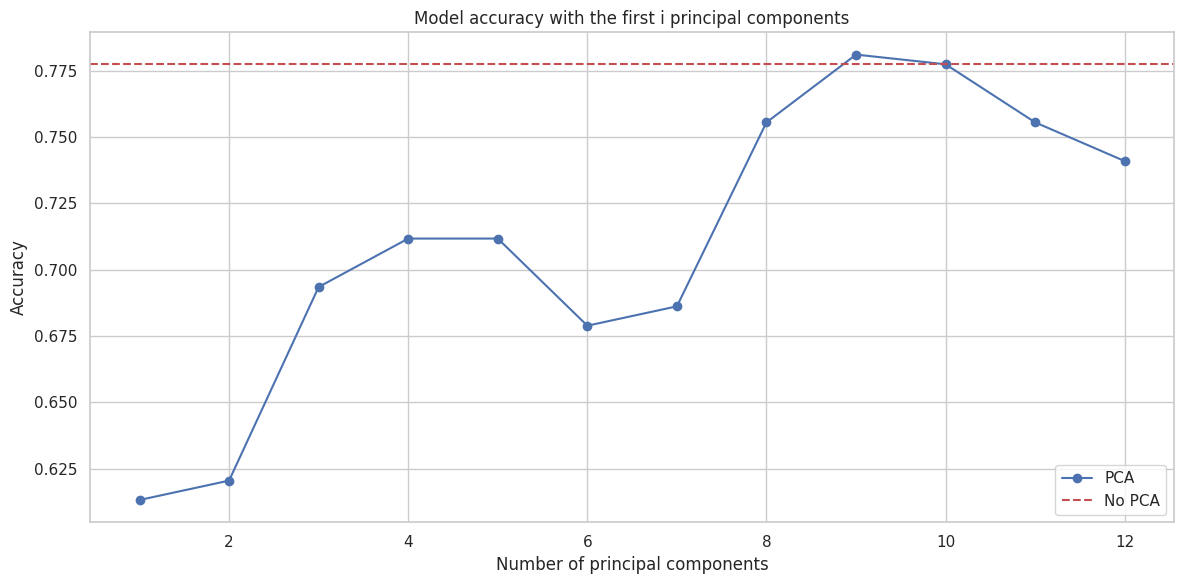

In [23]:
validate_pca(X_train, X_test, y_train, y_test, X, X_scaled, optimal_components)

In [24]:
# 4. Prediction model

selected_columns

['item_id',
 'cat_id',
 'merchant_id',
 'brand_id',
 'time_stamp',
 'action_type',
 'age_range_x',
 'gender_x',
 'avg_actions_per_age_x',
 'avg_actions_per_gender_x',
 'total_actions',
 'clicks',
 'add_to_carts',
 'purchases',
 'add_to_favourites',
 'unique_items',
 'unique_categories',
 'age_range_y',
 'gender_y',
 'avg_actions_per_age_y',
 'avg_actions_per_gender_y']

In [25]:
# Prepare the data
# selected_columns = ['item_id', 'cat_id', 'merchant_id', 'brand_id', 'time_stamp', 'action_type', 'age_range_x', 'gender_x',␣ ↪'avg_actions_per_age_x', 'avg_actions_per_gender_x', 'total_actions', 'clicks', 'add_to_carts', 'purchases', 'add_to_favourites', 'unique_items', 'unique_categories', 'age_range_y', 'gender_y', 'avg_actions_per_age_y', 'avg_actions_per_gender_y']
# X = main_dataset_merged[selected_columns]
# y = main_dataset_merged['label']

# Initialize the logistic regression model
clf = LogisticRegression()

# Initialize the RFECV object with a logistic regression estimator and StratifiedKFold cross-validator
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring='accuracy') 

# Fit the RFECV object to the data
rfecv.fit(X, y)

# Get the optimal number of features and the corresponding feature mask
optimal_features = np.sum(rfecv.support_)
feature_mask = rfecv.support_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [26]:
# Print the optimal number of features
print("Optimal number of features: ", optimal_features)

# Print the selected features
selected_features = np.array(selected_columns)[feature_mask]
print("Selected features: ", selected_features)

Optimal number of features:  18
Selected features:  ['cat_id' 'merchant_id' 'time_stamp' 'action_type' 'age_range_x'
 'gender_x' 'avg_actions_per_age_x' 'avg_actions_per_gender_x'
 'total_actions' 'clicks' 'add_to_carts' 'purchases' 'add_to_favourites'
 'unique_items' 'unique_categories' 'age_range_y' 'gender_y'
 'avg_actions_per_age_y']


In [27]:
# Use only the optimal features
X_optimal = X.iloc[:, feature_mask]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_optimal, y, test_size=0.2, random_state=42)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.50      0.63       135
         1.0       0.65      0.93      0.77       139

    accuracy                           0.72       274
   macro avg       0.76      0.71      0.70       274
weighted avg       0.76      0.72      0.70       274

Confusion Matrix:



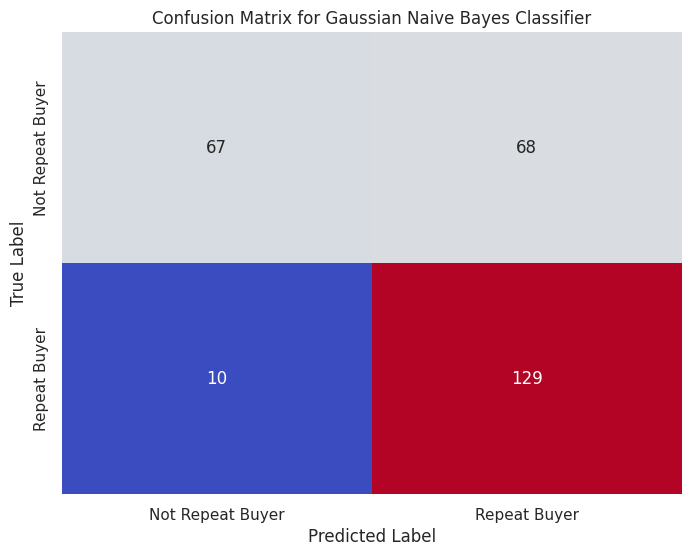

In [28]:
# Bayes Classifier to get identify the customers who will be a repeat buyer or not.

# Create a Gaussian Naive Bayes classifier and fit it to the training data
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_gnb = gnb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred_gnb)

# Print the classification report and confusion matrix 
print("Classification Report:\n", classification_report(y_test, y_pred_gnb)) 
print("Confusion Matrix:\n",)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=['Not Repeat Buyer', 'Repeat Buyer'], yticklabels=['Not Repeat Buyer', 'Repeat Buyer'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Gaussian Naive Bayes Classifier') 
plt.show()

In [29]:
# nearest neighbors and Parzen windows for classification

from sklearn.neighbors import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):

  def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth = bandwidth
    self.kernel = kernel

  def fit(self, X, y):
    self.classes_ = np.sort(np.unique(y))
    training_sets = [X[y == yi] for yi in self.classes_]
    self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi) for Xi in training_sets]
    self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets] 
  
    return self

  def predict_proba(self, X):
    logprobs = np.array([model.score_samples(X) for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_) 
    return result / result.sum(axis=1, keepdims=True)

  def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

In [30]:
# Train and evaluate the KDE classifier
kde = KDEClassifier(bandwidth=1.0, kernel='gaussian')
kde.fit(X_train, y_train)
y_pred_kde = kde.predict(X_test)

<ipython-input-29-d7becb3611b0>:24: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(axis=1, keepdims=True)


In [31]:
# Train and evaluate the KNN classifier
k_values = list(range(1, 21))

distance_metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
param_grid = {
    'n_neighbors': k_values,
    'metric': distance_metrics
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

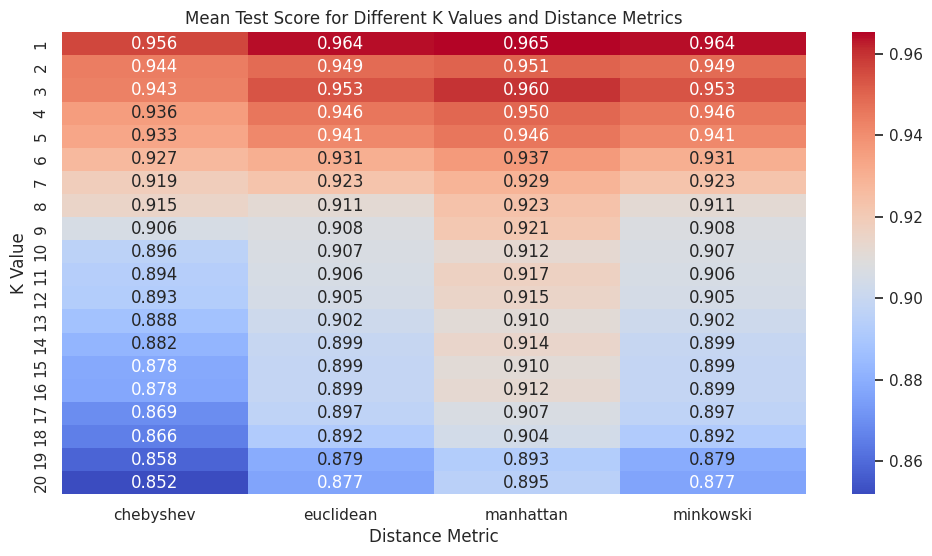

In [32]:
# comparion of the results of different K values and distance metrics

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results['k'] = cv_results['param_n_neighbors']
cv_results['metric'] = cv_results['param_metric']
cv_results['mean_test_score'] = cv_results['mean_test_score']
pivot_table = cv_results.pivot_table(index='k', columns='metric', values='mean_test_score')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='coolwarm', cbar=True)

plt.title('Mean Test Score for Different K Values and Distance Metrics')
plt.xlabel('Distance Metric')
plt.ylabel('K Value')
plt.show()

In [33]:
print("Best K value:", grid_search.best_params_['n_neighbors'])
print("Best distance metric:", grid_search.best_params_['metric'])

Best K value: 1
Best distance metric: manhattan


In [34]:
knn = KNeighborsClassifier(n_neighbors=3, metric = "manhattan")
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)


KNN Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       135
         1.0       0.96      0.98      0.97       139

    accuracy                           0.97       274
   macro avg       0.97      0.97      0.97       274
weighted avg       0.97      0.97      0.97       274


KDE Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       135
         1.0       0.98      0.87      0.92       139

    accuracy                           0.92       274
   macro avg       0.93      0.92      0.92       274
weighted avg       0.93      0.92      0.92       274



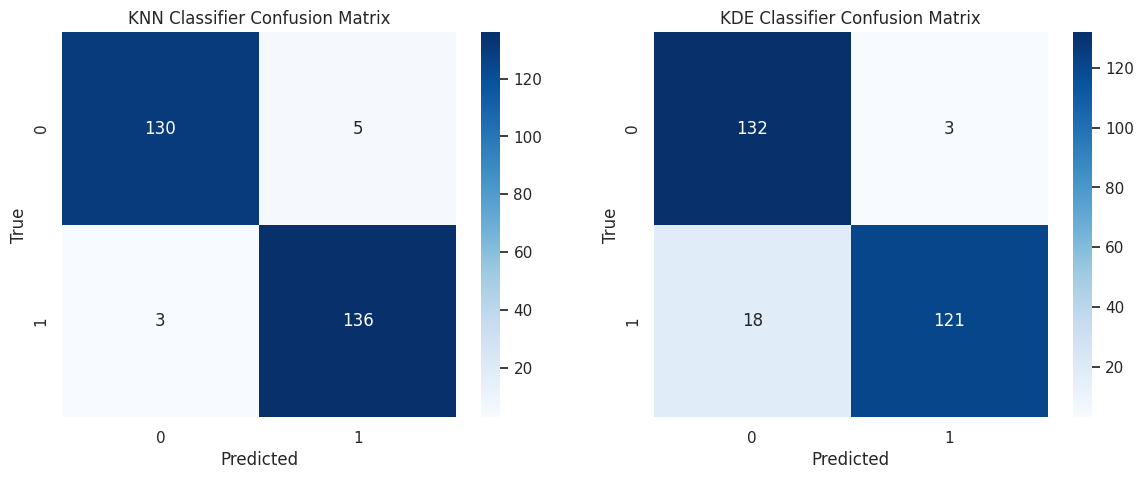

In [35]:
print("\nKNN Classifier Classification Report:") 
print(classification_report(y_test, y_pred_knn))
print("\nKDE Classifier Classification Report:") 
print(classification_report(y_test, y_pred_kde))

# KNN Classifier Confusion Matrix
knn_cm = confusion_matrix(y_test, y_pred_knn) 

# KDE Classifier Confusion Matrix
kde_cm = confusion_matrix(y_test, y_pred_kde) 

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(knn_cm, annot=True, cmap='Blues', fmt='d', ax=ax1) 
ax1.set_title("KNN Classifier Confusion Matrix") 
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

sns.heatmap(kde_cm, annot=True, cmap='Blues', fmt='d', ax=ax2) 
ax2.set_title("KDE Classifier Confusion Matrix") 
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")
plt.show()

In [36]:
# Create a simple feed-forward neural network model with early stopping
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000, early_stopping=True, random_state=42)

# Train the model on the resampled data
mlp.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp.predict(X_test)

# y_test = y_train_resampled
# Calculate metrics
mlp_accuracy = accuracy_score(y_test, y_pred_mlp) 
mlp_precision = precision_score(y_test, y_pred_mlp)
mlp_recall = recall_score(y_test, y_pred_mlp) 
mlp_f1 = f1_score(y_test, y_pred_mlp)
mlp_auc_roc = roc_auc_score(y_test, y_pred_mlp)


print("Accuracy:", mlp_accuracy)
print("Precision:", mlp_precision)
print("Recall:", mlp_recall)
print("F1-score:", mlp_f1)
print("AUC-ROC:", mlp_auc_roc)

Accuracy: 0.8759124087591241
Precision: 0.8143712574850299
Recall: 0.9784172661870504
F1-score: 0.888888888888889
AUC-ROC: 0.8743938182787104


In [38]:
# 5.Model evaluation

# Performance Evaluation

def calculate_metrics(y_true, y_pred, label): 
  accuracy = accuracy_score(y_true, y_pred) 
  precision = precision_score(y_true, y_pred) 
  recall = recall_score(y_true, y_pred)

  f1 = f1_score(y_true, y_pred)
  auc_roc = roc_auc_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)

  # print(cm)
  # Plot the confusion matrices
  plt.clf()
  fig, (ax1) = plt.subplots(1, 1, figsize=(14, 5))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax1) 
  ax1.set_title(f"{label} Classifier Confusion Matrix") 
  ax1.set_xlabel("Predicted")
  ax1.set_ylabel("True")

  plt.show()

  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc_roc': auc_roc}

<Figure size 640x480 with 0 Axes>

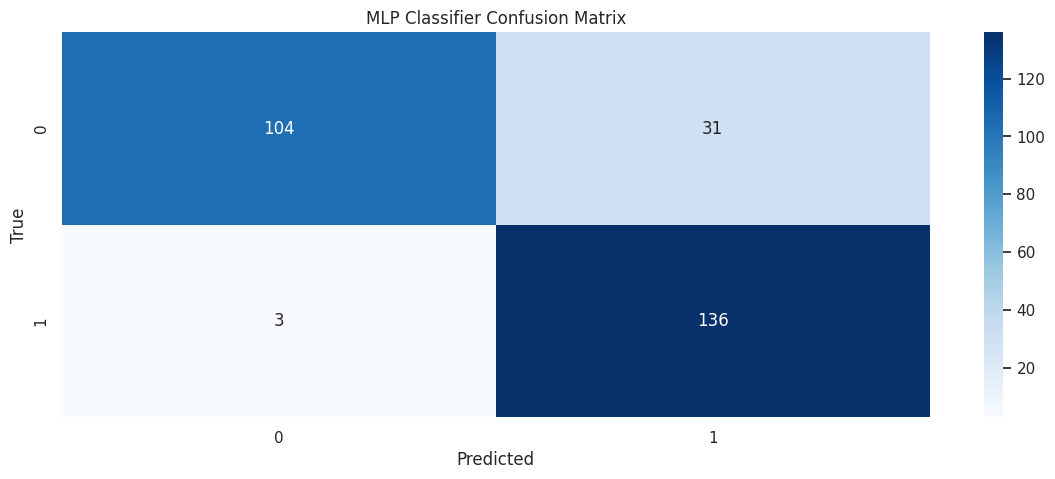

<Figure size 640x480 with 0 Axes>

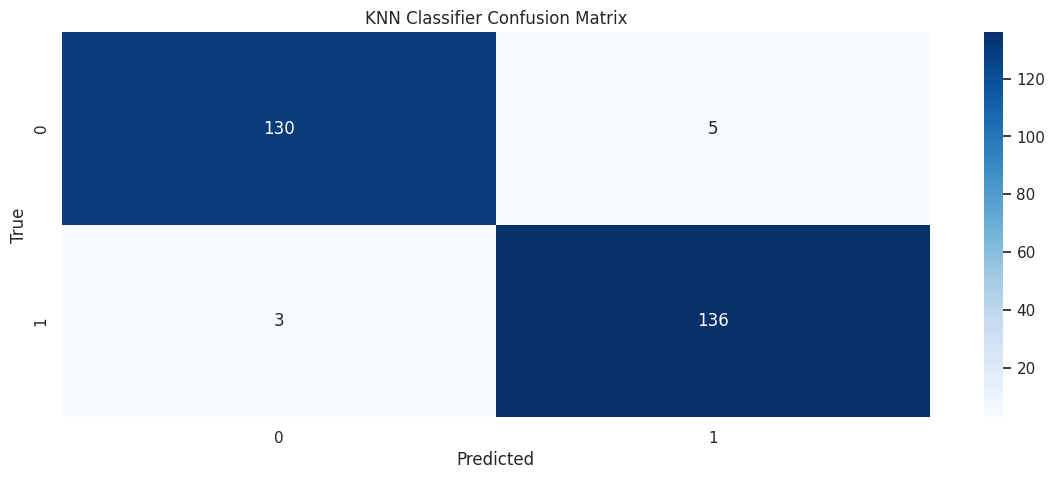

<Figure size 640x480 with 0 Axes>

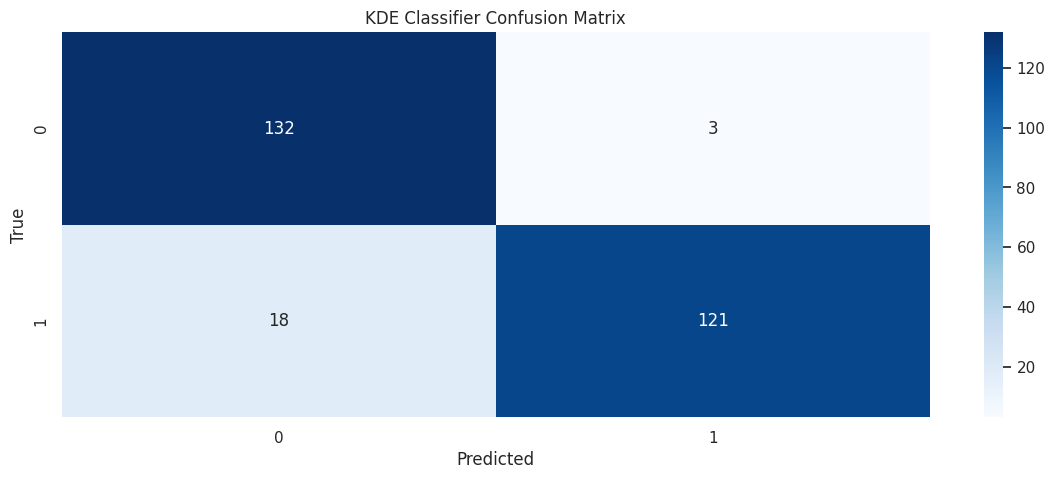

<Figure size 640x480 with 0 Axes>

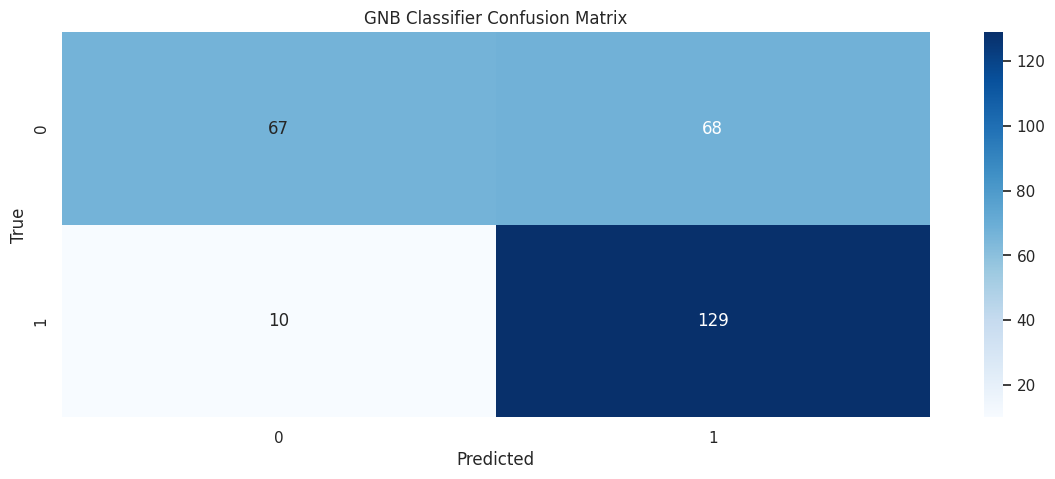

In [39]:
mlp_metrics = calculate_metrics(y_test, y_pred_mlp, "MLP")
knn_metrics = calculate_metrics(y_test, y_pred_knn, "KNN")
kde_metrics = calculate_metrics(y_test, y_pred_kde, "KDE")
gnb_metrics = calculate_metrics(y_test, y_pred_gnb, "GNB")

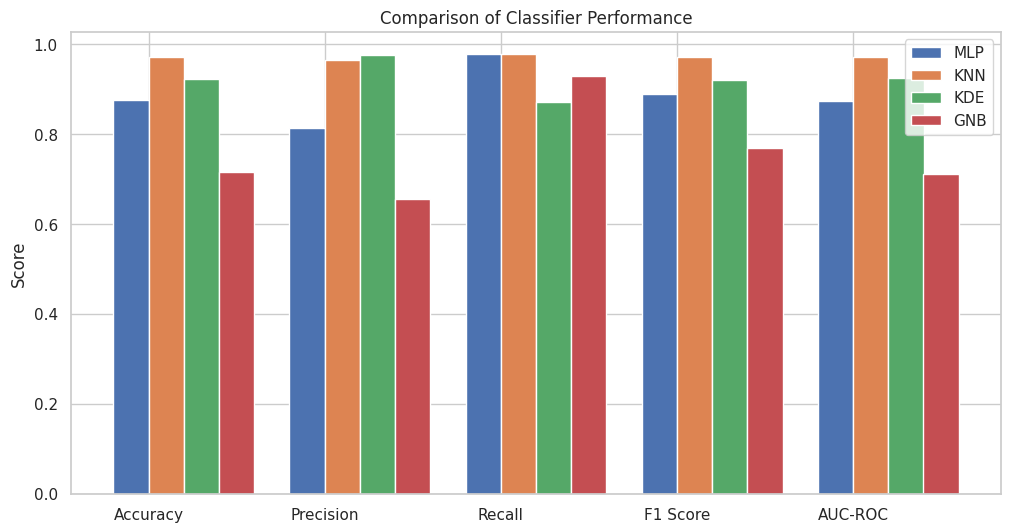

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and data for the plot
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
data = [mlp_metrics.values(), knn_metrics.values(), kde_metrics.values(), gnb_metrics.values()]
classifiers = ['MLP', 'KNN', 'KDE', 'GNB']

# Create a grouped bar plot
x = np.arange(len(labels))

width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
for idx, (classifier, classifier_data) in enumerate(zip(classifiers, data)): 
  ax.bar(x + (idx * width), classifier_data, width, label=classifier)

ax.set_ylabel('Score')
ax.set_title('Comparison of Classifier Performance')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()